<a href="https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/verbose/alphafold_noTemplates_yesMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#AlphaFold

In [ ]:
#################
# WARNING 
#################
# - This notebook is intended as a "quick" demo, it disables many aspects of the full alphafold2 pipeline 
#   (input MSA/templates and number of models). For best results, we recommend using the full pipeline: 
#   https://github.com/deepmind/alphafold
# - That being said, it was found that input templates and amber-relax did not help much.
#   The key input features are the MSA (Multiple Sequence Alignment) of related proteins. Where you see a 
#   significant drop in predicted accuracy when MSA < 30, but only minor improvements > 100. 
# - This notebook does NOT include the alphafold2 MSA generation pipeline, and is designed to work with a
#   single sequence, custom MSA input (that you can upload) or MMseqs2 webserver.
# - Single sequence mode is particularly useful for denovo designed proteins (where there are no sequence
#   homologs by definition). For natural proteins, an MSA input will make a huge difference.

#################
# EXTRA
#################
# AlphaFold "human-friendly" VERSION: https://colab.research.google.com/drive/1LVPSOf4L502F21RWBmYJJYYLDlOU2NTL
# AlphaFold w/o amber-relax: https://colab.research.google.com/drive/1qWO6ArwDMeba1Nl57kk_cQ8aorJ76N6x
# RoseTTAFold: https://colab.research.google.com/drive/1MBht6Nvy2vQCqPSdVg73zbiWZIvt7Zx0
#################

In [ ]:
%%bash
# download model
git clone https://github.com/deepmind/alphafold.git
mv alphafold alphafold_
mv alphafold_/alphafold .
# remove "END" from PDBs, otherwise biopython complains
sed -i "s/pdb_lines.append('END')//" alphafold/common/protein.py
sed -i "s/pdb_lines.append('ENDMDL')//" alphafold/common/protein.py

Cloning into 'alphafold'...


In [ ]:
%%bash
# download model params (~1 min)
wget -qnc https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar
mkdir params
tar -xf alphafold_params_2021-07-14.tar -C params/
rm alphafold_params_2021-07-14.tar

In [ ]:
%%bash
pip -q install biopython
pip -q install dm-haiku
pip -q install ml-collections

# install py3Dmol for visualization
pip -q install py3Dmol

In [ ]:
%%bash
# install openmm for refinement
wget -qnc https://git.scicore.unibas.ch/schwede/openstructure/-/raw/7102c63615b64735c4941278d92b554ec94415f8/modules/mol/alg/src/stereo_chemical_props.txt
mv stereo_chemical_props.txt alphafold/common/
wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh 
bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local 2>&1 1>/dev/null
conda install -y -q -c conda-forge openmm=7.5.1 python=3.7 pdbfixer 2>&1 1>/dev/null
cd /usr/local/lib/python3.7/site-packages
patch -p0 < /content/alphafold_/docker/openmm.patch

patching file simtk/openmm/app/topology.py
Hunk #1 succeeded at 353 (offset -3 lines).


In [ ]:
import os
import numpy as np
import pickle
import py3Dmol
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/usr/local/lib/python3.7/site-packages/')
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from alphafold.common import protein
from alphafold.data import pipeline
from alphafold.data import templates
from alphafold.model import data
from alphafold.model import config
from alphafold.model import model
from alphafold.relax import relax

In [ ]:
# setup which model params to use
# note: for this demo, we only use model 1, for all five models uncomments the others!
model_runners = {}
models = ["model_1"] #,"model_2","model_3","model_4","model_5"]
for model_name in models:
  model_config = config.model_config(model_name)
  model_config.data.eval.num_ensemble = 1
  model_params = data.get_model_haiku_params(model_name=model_name, data_dir=".")
  model_runner = model.RunModel(model_config, model_params)
  model_runners[model_name] = model_runner

In [ ]:
import numpy as np

In [ ]:
def mk_mock_template(query_sequence):
  # since alphafold's model requires a template input
  # we create a blank example w/ zero input, confidence -1
  ln = len(query_sequence)
  output_templates_sequence = "-"*ln
  output_confidence_scores = np.full(ln,-1)
  templates_all_atom_positions = np.zeros((ln, templates.residue_constants.atom_type_num, 3))
  templates_all_atom_masks = np.zeros((ln, templates.residue_constants.atom_type_num))
  templates_aatype = templates.residue_constants.sequence_to_onehot(output_templates_sequence,
                                                                    templates.residue_constants.HHBLITS_AA_TO_ID)
  template_features = {'template_all_atom_positions': templates_all_atom_positions[None],
                       'template_all_atom_masks': templates_all_atom_masks[None],
                       'template_sequence': [f'none'.encode()],
                       'template_aatype': np.array(templates_aatype)[None],
                       'template_confidence_scores': output_confidence_scores[None],
                       'template_domain_names': [f'none'.encode()],
                       'template_release_date': [f'none'.encode()]}
  return template_features

In [ ]:
def predict_structure(prefix, feature_dict, model_runners, do_relax=True, random_seed=0):  
  """Predicts structure using AlphaFold for the given sequence."""

  # Run the models.
  plddts = {}
  for model_name, model_runner in model_runners.items():
    processed_feature_dict = model_runner.process_features(feature_dict, random_seed=random_seed)
    prediction_result = model_runner.predict(processed_feature_dict)
    unrelaxed_protein = protein.from_prediction(processed_feature_dict,prediction_result)
    unrelaxed_pdb_path = f'{prefix}_unrelaxed_{model_name}.pdb'
    plddts[model_name] = prediction_result['plddt']

    print(f"{model_name} {plddts[model_name].mean()}")

    with open(unrelaxed_pdb_path, 'w') as f:
      f.write(protein.to_pdb(unrelaxed_protein))

    if do_relax:
      # Relax the prediction.
      amber_relaxer = relax.AmberRelaxation(max_iterations=0,tolerance=2.39,
                                            stiffness=10.0,exclude_residues=[],
                                            max_outer_iterations=20)      
      relaxed_pdb_str, _, _ = amber_relaxer.process(prot=unrelaxed_protein)
      relaxed_pdb_path = f'{prefix}_relaxed_{model_name}.pdb'
      with open(relaxed_pdb_path, 'w') as f: f.write(relaxed_pdb_str)

  return plddts

# Single sequence input (no MSA, no templates)

In [ ]:
# Change this line to the sequence you want to predcit
query_sequence = "GWSTELEKHREELKEFLKKEGITNVEIRIDNGRLEVRVEGGTERLKRFLEELRQKLEKKGYTVDIKIE"

In [ ]:
%%time
feature_dict = {
    **pipeline.make_sequence_features(sequence=query_sequence,
                                      description="none",
                                      num_res=len(query_sequence)),
    **pipeline.make_msa_features(msas=[[query_sequence]],
                                 deletion_matrices=[[[0]*len(query_sequence)]]),
    **mk_mock_template(query_sequence)
}
plddts = predict_structure("test",feature_dict,model_runners)

Instructions for updating:
Use fn_output_signature instead


Instructions for updating:
Use fn_output_signature instead


model_1 83.72061388759155


/usr/local/lib/python3.7/dist-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1173
  PDBConstructionWarning,


CPU times: user 2min 34s, sys: 4.88 s, total: 2min 39s
Wall time: 2min 27s


/usr/local/lib/python3.7/dist-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1173
  PDBConstructionWarning,


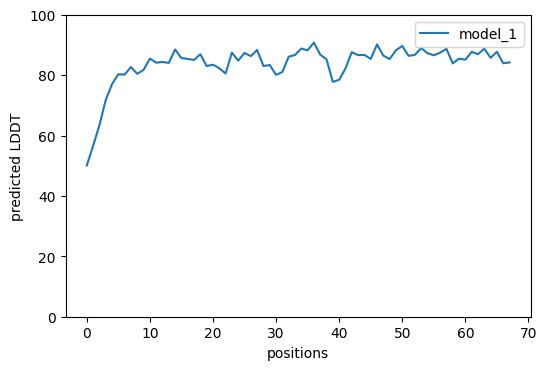

In [ ]:
# confidence per position
plt.figure(dpi=100)
for model,value in plddts.items():
  plt.plot(value,label=model)
plt.legend()
plt.ylim(0,100)
plt.ylabel("predicted LDDT")
plt.xlabel("positions")
plt.show()

In [ ]:
  p = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
  p.addModel(open("test_relaxed_model_1.pdb",'r').read(),'pdb')
  p.setStyle({'cartoon': {'color':'spectrum'}})
  p.zoomTo()
  p.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
  p = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
  p.addModel(open("test_relaxed_model_1.pdb",'r').read(),'pdb')
  p.setStyle({'cartoon': {'color':'spectrum'},'stick':{}})
  p.zoomTo()
  p.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Custom MSA input

In [ ]:
%%bash
# for this demo we will download a premade MSA input
wget -qnc https://gremlin2.bakerlab.org/db/ECOLI/fasta/P0A8I3.fas

In [ ]:
msa, deletion_matrix = pipeline.parsers.parse_a3m("".join(open("P0A8I3.fas","r").readlines()))
query_sequence = msa[0]

In [ ]:
%%time
feature_dict = {
    **pipeline.make_sequence_features(sequence=query_sequence,
                                      description="none",
                                      num_res=len(query_sequence)),
    **pipeline.make_msa_features(msas=[msa],deletion_matrices=[deletion_matrix]),
    **mk_mock_template(query_sequence)
}
plddts = predict_structure("yaaa",feature_dict,model_runners)

model_1 97.32114520685755


/usr/local/lib/python3.7/dist-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4184
  PDBConstructionWarning,


CPU times: user 6min, sys: 18.1 s, total: 6min 18s
Wall time: 4min 34s


/usr/local/lib/python3.7/dist-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4184
  PDBConstructionWarning,


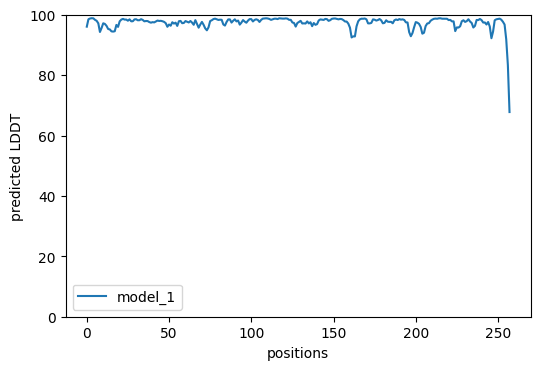

In [ ]:
# confidence per position
plt.figure(dpi=100)
for model,value in plddts.items():
  plt.plot(value,label=model)
plt.legend()
plt.ylim(0,100)
plt.ylabel("predicted LDDT")
plt.xlabel("positions")
plt.show()

In [ ]:
  p = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
  p.addModel(open("yaaa_relaxed_model_1.pdb",'r').read(),'pdb')
  p.setStyle({'cartoon': {'color':'spectrum'}})
  p.zoomTo()
  p.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

#MSA from MMseqs2

In [ ]:
##############################
# Where do I get an MSA?
##############################
# For any "serious" use, I would recommend using the alphafold2 pipeline to make the MSAs, 
# since this is what it was trained on. 

# That being said, part of the MSA generation pipeline (specifically searching against uniprot database using hhblits)
# can be done here: https://toolkit.tuebingen.mpg.de/tools/hhblits
# Alternatively, using the SUPER FAST MMseqs2 pipeline below

# for a HUMAN FRIENDLY version see:
# https://colab.research.google.com/drive/1LVPSOf4L502F21RWBmYJJYYLDlOU2NTL

In [ ]:
%%bash
apt-get -qq -y update 2>&1 1>/dev/null
apt-get -qq -y install jq curl zlib1g gawk 2>&1 1>/dev/null

In [ ]:
# save query sequence to file
name = "YAII"
query_sequence = "MTIWVDADACPNVIKEILYRAAERMQMPLVLVANQSLRVPPSRFIRTLRVAAGFDVADNEIVRQCEAGDLVITADIPLAAEAIEKGAAALNPRGERYTPATIRERLTMRDFMDTLRASGIQTGGPDSLSQRDRQAFAAELEKWWLEVQRSRG"
with open(f"{name}.fasta","w") as out: out.write(f">{name}\n{query_sequence}\n")

In [ ]:
%%bash -s "$name"
# build msa using the MMseqs2 search server
ID=$(curl -s -F q=@$1.fasta -F mode=all https://a3m.mmseqs.com/ticket/msa | jq -r '.id')
STATUS=$(curl -s https://a3m.mmseqs.com/ticket/${ID} | jq -r '.status')
while [ "${STATUS}" == "RUNNING" ]; do
    STATUS=$(curl -s https://a3m.mmseqs.com/ticket/${ID} | jq -r '.status')
    sleep 1
done
if [ "${STATUS}" == "COMPLETE" ]; then
    curl -s https://a3m.mmseqs.com/result/download/${ID}  > $1.tar.gz
    tar xzf $1.tar.gz
    tr -d '\000' < uniref.a3m > $1.a3m
else
    echo "MMseqs2 server did not return a valid result."
    exit 1
fi
echo "Found $(grep -c ">" $1.a3m) sequences (after redundacy filtering)"

Found 3090 sequences (after redundacy filtering)


In [ ]:
msa, deletion_matrix = pipeline.parsers.parse_a3m("".join(open(f"{name}.a3m","r").readlines()))
query_sequence = msa[0]

In [ ]:
%%time
feature_dict = {
    **pipeline.make_sequence_features(sequence=query_sequence,
                                      description="none",
                                      num_res=len(query_sequence)),
    **pipeline.make_msa_features(msas=[msa],deletion_matrices=[deletion_matrix]),
    **mk_mock_template(query_sequence)
}
plddts = predict_structure(name,feature_dict,model_runners)

model_1 91.07940303301928


/usr/local/lib/python3.7/dist-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2394
  PDBConstructionWarning,


CPU times: user 3min 21s, sys: 8.02 s, total: 3min 29s
Wall time: 2min 51s


/usr/local/lib/python3.7/dist-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2394
  PDBConstructionWarning,


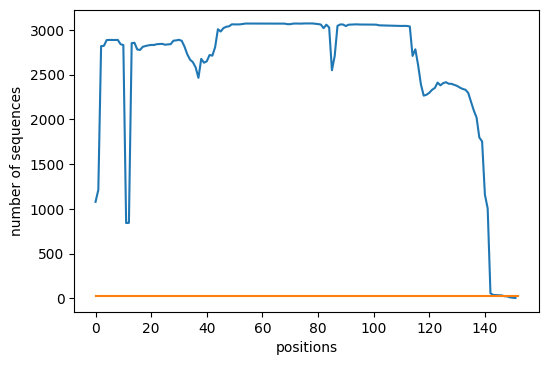

In [ ]:
plt.figure(dpi=100)
plt.plot((feature_dict["msa"] != 21).sum(0))
plt.plot([0,len(query_sequence)],[30,30])
plt.xlabel("positions")
plt.ylabel("number of sequences")
plt.show()

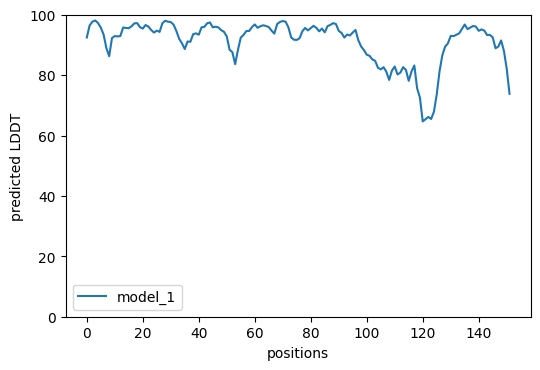

In [ ]:
# confidence per position
plt.figure(dpi=100)
for model,value in plddts.items():
  plt.plot(value,label=model)
plt.legend()
plt.ylim(0,100)
plt.ylabel("predicted LDDT")
plt.xlabel("positions")
plt.show()

In [ ]:
  p = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
  p.addModel(open(f"{name}_unrelaxed_model_1.pdb",'r').read(),'pdb')
  p.setStyle({'cartoon': {'color':'spectrum'}})
  p.zoomTo()
  p.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol